In [ ]:
!pip install -U tensorflow

In [2]:
import numpy as np 
from scipy import linalg
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

pl = np.load('rts_gmlc_pl.npy')
va = np.load('rts_gmlc_va.npy')
vm = np.load('rts_gmlc_vm.npy')

concat = np.concatenate((pl,va,vm),axis=1)
lstm_concat = concat[:,0]


# Creating sequential data for LSTM

For LSTM to train, it need the correct data format, we need to transform the original time series data into multiple sequence format.
For exmaple, if we have a sequential data go from 1-10
```
origianl time series data:

[1,2,3,4,5,6,7,8,9,10,...]

if we want to take 4 timestep and predict the next 2 timestep, we need to transform the data into this format.

network input: [1,2,3,4]  --> target : [5,6]
network input: [2,3,4,5]  --> target : [6,7]
network input: [3,4,5,6]  --> target : [7,8]

```

```seq_length``` is the LSTM network output length

In [19]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-seq_length):
        x = data[i:i+seq_length]
        y = data[i + seq_length : i + seq_length + seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

#train test split
test_data_size = 5000
train_data = lstm_concat[:-test_data_size]
test_data = lstm_concat[-test_data_size:]

#take 120 timestep in, output the next 120 timestep.
seq_length = 120
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# we need (n, 1) shape instead of (n,)
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test,axis=2)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import tensorflow
model = Sequential([layers.Input((seq_length,1)),
                    layers.LSTM(64),
                    layers.Dense(seq_length,activation='relu')])

#load pre_trained model 
model = tensorflow.keras.models.load_model('/content/trained_lstm')

In [7]:
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.002),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1)
model.save('/content/trained_lstm',save_format="h5")

3131/3131 [==============================] - 173s 55ms/step - loss: 140.7765 - mean_absolute_error: 4.7555 - val_loss: 116.2444 - val_mean_absolute_error: 5.4638


In [8]:
train_predictions = model.predict(X_test)

149/149 [==============================] - 4s 19ms/step


In [9]:
result = []
for i in range(train_predictions.shape[0]):
  result.append(train_predictions[i][0])

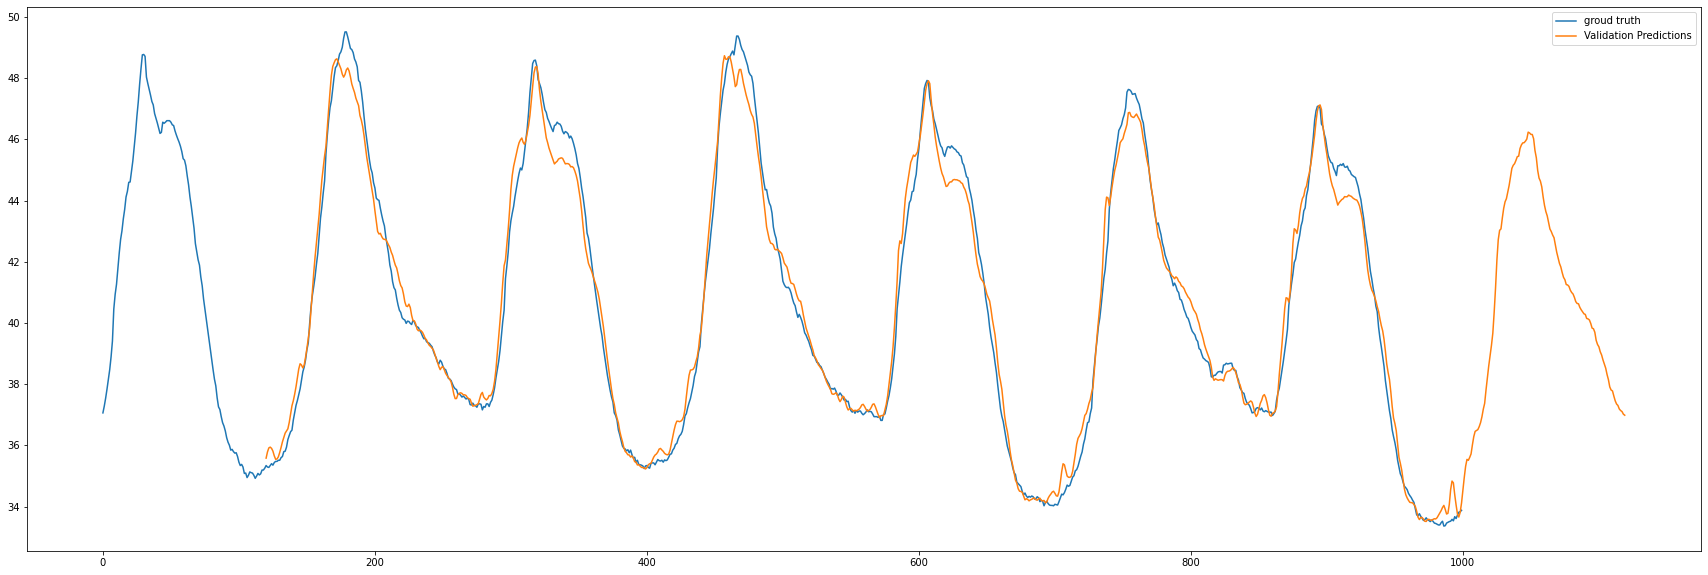

In [18]:
start = 0
finish = 1000
size = finish - start
plt.figure(figsize=(30,10))
plt.plot(np.arange(0,size),concat[-test_data.shape[0]:-test_data.shape[0]+size,0])
plt.plot(np.arange(seq_length,size+seq_length),result[0:size])
# plt.plot(np.arange(size,size+seq_length),concat[-test_data.shape[0]+size:-test_data.shape[0] + size + seq_length,0])
plt.legend(['groud truth','Validation Predictions', 'prediction ground truth'])